# 神经网络学习笔记
## 0-相关概念及数学原理
> 2019-18-Mai 佚之狗 https://github.com/HookeLiu QQ: 616471607

机器学习是一大类算法的统称, 这些算法能根据"经验"自动优化以求最优解. 神经网络算法作为机器学习的一种实现, 实质上也是一种优化算法, 它能自动提取输入数据的特征并进行分类.可以表示成`optimizer.minimize( Loss({x,y},θ) + Ω(θ) )`(其中Loss()表示损失函数, {x,y}表示数据集, θ表示权重参数, Ω()表示正则化)

人工神经网络在**功能上**借鉴了生物神经网络, 即: 输入和权重相当于生物神经网相当于生物神经网络树突的连接强度; 对输入的处理(总和以及激活函数)就相当于生物神经细胞对刺激的动作.对于生物神经细胞来说这个输入通常是神经递质的类型和量,这些递质对细胞膜的刺激会使得膜电位变化并且会累加到轴突,当轴突上的膜电位达到某一程度时细胞体就会向后传递.生物细胞受刺激后发出的信号实际上是密度不同的脉冲,称为发放率,和PDM(脉冲密度调制)很相似.

但实际上, 就目前来说, 人工神经网络都是在"拟合一个函数", 实际上就是把数学建模或者说特征提取的工作交给神经网络. 比如每两个神经元如果权重互为相反数, 调节权重和偏置就能调节一个“矩形波”, 以“极限”的思想, 无数个“矩形波”可以拟合出任何函数. 人工神经元只是模仿生物神经元的基本功能--信息输入→模式加工→动作输出,具体来说就是`数据*权重+偏置`作为输→传递函数作为细胞体处理强度→传输函数作为输出传递到轴突.
一个人工神经元实质上的功能就是把输入数据×权重再求和之后加上偏置作为传递函数的输入, 即`out = activFuc( ∑(W.T*X+b) )`

In [1]:
import numpy as np # 使用numpy库以便计算

In [2]:
def neron(w, x, b):
    sum = np.dot(w,x) + b
    out = relu(sum)
    return {'out':out, 'inSum':sum}

神经网络之所以能区分那么多的特征, 是因为网络的每一层都在处理不同层次的特征, 要想实现实现每个层次都能"总结"上一层的信息, 那就需要使用非线性的激活函数. 因为如果使用线性的话, 全连接的权重就没有层次关系了, 就相当于所有的层次都压缩到了一层, 神经网络处理特征的能力就会下降. 使用非线性激活函数就相当于让每个前一层的输出都逐层嵌套到后一层的激活函数中.
常用的激活函数有:sigmoid/tanh/relu/elu等, 对于浅层神经网络来说使用什么激活函数的区别都不大. 
sigmoid是把任意实数压缩到[0,1]范围, 输入为0的时候输出是0.5, 所以通常可以表示"概率", 也就是能把任意实数映射到概率. 但此函数的导数最大值为1/4,这意味着很容易造成梯度消失; sigmoid是个非常经典的非线性激活函数, 历史悠久, 来源于最大熵和拉格朗日数乘法.
tanh则是把任意实数压缩至[-1,1],相比sigmoid来说是0均匀分布,可以缓解梯度消失的问题;
relu是把负数部分取0,正数部分为线性,所以没有梯度消失的问题,但relu的输出非负所以会出现梯度爆炸(即神经元不会再被激活).
为了方便反向传播, 定义激活函数的时候最好顺便定义其导函数.
本文示例的感知机是一种简单的二分类器, 相当于线性拟合(中学数学的ax+b=0), 就相当于"尝试画出一条直线(称为决策边界)把两种数据分开", 所以使用的激活函数是sign函数(out<0:-1,out = 0:0,out>=0:1), 因为感知机参数所绘制的分割直线上方的点大于0而下方的小于0.

In [3]:
def sigmoid(x):
    # f(x)=1/(1+e^-x), 求导:f'(x) = f(x) * (1 - f(x))
    return 1 / ( 1 + np.exp(-x) )
def deriv_sigmoid(x):
    fx = sigmoid(x)
    return fx * (1 - fx)
def tanh(x):                               
    # f(x)=(e^x−e^−x)/(e^x+e^−x), 求导: f'(x) = 1 - f^2(x)                     
    return ( np.exp( np.array(x) ) - np.exp( -1 * np.array(x) ) ) / ( np.exp( np.array(x) ) + np.exp( -1 * np.array(x) ) )
def deriv_tanh(x):
    fsx= tanh(x) * tanh(x)
    return 1 - fsx
def relu(x):
    # f(x)=max(0,x), 求导: f'(x) = 1 if x>0 else 0
    return x if x>0 else 0
def deriv_relu(x):
    return 1 if x>0 else 0

神经网络可以看成一个"黑盒", 输入一组数据就会输出一组数据, 为了评价一个模型的"好坏"也就是与预期的偏离程度, 就需要定义一个`损失函数`. 定义损失函数并没有一个确切的要求, 通常是根据实际任务需求选择或制定一个合理的函数, 比如SVM(Support Vector Machine, 支持向量机)的损失函数是HL(Hinge Loss, 合页损失函数)`L[y(w.T*x+b)] = Abs[1-y(w.Txb)]`(常用形式是Li = ∑max(0, sj-syi+∆)); 最典型的CEE(Cross Entropy Error,交叉熵误差)`J(θ)=−1/m ∑(i=1,m)( yi*log⁡( hθ(xi) )+(1−yi)*log⁡( 1−hθ(xi) ) )`; 适用于线性回归的MSE(Mean Squared Error, 均方误差)`loss = 1/m ∑(i=1,m) ( (yi−yHeadi)^2 )`等. 

主旨就是定义一个函数用于衡量预测与期望值之间的差异, 并通过训练调整参数使得这个差异最小化(优化). 并且, 通过修正参数使损失函数最小化的常用方法是对各个参数做`梯度下降`. 也就是求出各个参数的梯度(可以简单当成"参数对损失函数的影响程度及方向", 通常做法是求损失函数对参数的偏导数), 然后各个参数沿着梯度相反的方向(也就是乘个-1)增加.

所谓的"模型好坏"也可以理解成"模型的熵", 熵本身是表示"不确定程度". 对于机器学习来说, 一切信息都存在概率分布, 信息熵越大则信息量越大, 这个分布也就越难以确定.交叉熵是信息论的一个概念, 从字面意思上来说是指"真实分布与非真实分布的交叉", 描述两个概率分布情况的差异, 可以简单理解成"算法使用非真实分布预测出的结果与真实分布情况的不确定性", 数值越小则模型越接近期望. 一般的表达式为`H(p,q) = -∑(i=1,m) ( p(x)*log( q(x) ) )`(其中p代表期望值,q代表预测值).

In [4]:
def loss_HL(lable, inSum): 
    # 感知机是一种二分类线性分类模型, 可以使用合页损失函数.Li = max(0, -lable*(ax+b)), 其中lable(ax+b)的绝对值代表样本到决策边界的距离 
    # 当样本点(xi,yi)被正确分类时且yi(a*xi+b)大于1时损失为0; 否则就是偏离程度(1-yi(ax+b))
    return np.max(0, -1 * lable * inSum)
def loss_MSE(pred, lable):
    # 均方误差通常是用于衡量两组数据之间的平均差异情况
    return np.mean( (lable - pred) ** 2  )

为了"训练网络", 也就是根据输入和标签调整参数使得网络参数最接近最优解, 就需要通过优化算法对损失函数进行优化. 最常用的优化方法是`梯度下降法(Gradient Descent)`, 它有很多的变体(BGD, SGD, MBGD等). 一些情况下使用`牛顿法`也是不错的.

其实**梯度相当于中学数学里`导数`概念的一个扩展**, 也就是说, 当只有一个参数(一元, 一个维度)的时候梯度的计算和导数的计算一致, 可以把梯度理解为求一个"多维空间"中某个参数在某点变化率最大的向量, 其大小为导数值(其实中学数学里的导数就是省略了方向的一元(一维空间)函数的梯度, 因为一元函数的梯度方向和自变量轴平行, 方向由正负号确定. 高中所学的导数可以近似视为"一元偏导数". 需要区分的是**梯度是矢量而某点的导数是个常量**). 它沿"最陡峭"的方向指向更大值, 而梯度下降就是让这个参数往梯度的反方向更新. 在一维曲线上过一点反应这个曲线变化率的是切线, 在高维空间中这样的直线则有很多条, 所以需要求每一个维度的`偏导数`以选择每一个维度的"切线". 在这里一个权重就是一个维度且一个偏置也是一个维度. 求梯度的操作和求偏导数的操作相同.

偏导数, 字面意思上就是"偏向于某个变量的导数", 就是把非这个变量的部分视为常数进行计算.
因为神经网络是逐层的, 所以损失函数总是可以对每个参数连续偏导的, 也就是说损失函数中某一个靠前的运算门可以根据其后一层的梯度来计算自身的梯度, 也叫链式求导, 这个过程叫反向传播. 用`链式求导法, z = f[u(x,y),v(x,y)]在(x,y)处的偏导数: ∂z/∂x = ∂f/∂u * ∂u/∂x + ∂f/∂v * ∂v/∂x ; ∂z/∂y = ∂f/∂u * ∂u/∂y + ∂f/∂v * ∂v/∂y`( 设u=u(x,y),v=v(xy),(x,y)处存在偏导数且z = f(u,v)在(u,v)处具有连续偏导数 )

反向传播的操作可以简单理解成"把正向传播的输出当做反向传播输入, 反向地依次传入每一个门的导函数, 最终求出损失函数对每一个参数的偏导数"

梯度下降表示为`θj =θj−α( ∂J(θ)/(∂θj) )`, 含义: 某个权重的更新是自身减去一个损失函数对权重偏导数的常数(`学习率`)倍, 即`某个权重的新值 = 旧值 - 学习速率*(损失函数对旧值的偏导数)`偏导数∂J(θ)/∂θj的定义是`1/m (i=1,m)〖(hθ(xi)−yi) xji 〗` 乘上一个常数项(0到1之间)的意义是在于控制更新的最大步幅, 防止更新参数的时候越过最优解而不能收敛(因为每一步迭代时参数的变化量难以确定, 如果正处于损失函数变化去势很大的点, 参数的变化也会很大, 过大的变化就无法到达最小值点). 

训练一个模型通常的套路是: 
> 1. 初始化权重和偏置(随机或者导入)
> 2. 将数据前向传播
> 3. 根据输出与预期的差异计算误差(损失)
> > * 误差可接受→计算下一组数据
> > * 误差过大→按梯度下降( θ-= LR*(∂J(θ)/(∂θj) )更新参数 (优化器)
> 4. 判断上一次迭代过程中是否更新了参数
> > * 更新了→继续迭代
> > * 没有更新(说明所有预测值和期望值的误差都可接受)→跳出, 结束训练

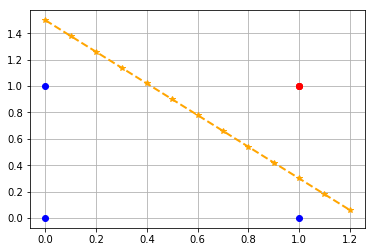

In [10]:
# 假定一个数据集, 假设目的是训练一个二输入与门
data = np.array([
    [1,1],[1,0],
    [0,1],[1,1],
    [1,1],[0,0]
])
true = np.array([
    [1],[0],
    [0],[1],
    [1],[0]
    
])
# 把数据集可视化
import matplotlib.pyplot as plt
plt.figure()
for i in range( len(data) ):
    if true[i] == 1: 
        plt.plot(data[i][0], data[i][1], 'ro')
    else:
        plt.plot(data[i][0], data[i][1], 'bo')
plt.grid(True)
# 根据肉眼观察, 这些点是线性可分的, 可以给出一个"分界线", 目测这条线可能会是-1.2x + 1.5 (当然，可能的组合是无数多的)
x = np.arange(13) * 0.1
line = -1.2 * x + 1.5
plt.plot(x, line, marker="*", linewidth=2, linestyle="--", color="orange")
plt.show()

In [6]:
# 例：一个单细胞的2输入1输出感知机
def init():
    w = np.random.randn(2) * 0.1        # 每个权重初始值必须要有些差异，否则梯度都一样就没办法训练了
    b = 0                               # 偏置对真个模型的影响不大, 初始值可以相对随意一些, 通常习惯取0
    print( "初始化了一个2输入感知机,初始参数为:w->%s,b->%s" %(w,b) )
    return [w,b]
def feedforward(w, b, inp):
    y = neron(w, inp, b)
    return {'weight':w, 'bias':b, 'pred':np.sign( y.get('out') ), 'inSum':y.get('inSum'), 'input':inp}    # 返回正向传播的相关参数以便处理和调试
def backpropagation(inp, pred, lable):  
    '''
    反向传播
    # 如前文所述, 反向传播其实可以用链式求导法求损失函数对各个参数的偏导数
    # 这里的一个节点可以拆分成3层门：3个乘法门(输入乘权重)→1个加法门(3个乘法门的结果与偏置相加)→1个tanh门(激活函数)→Pred[→1个HL门(损失函数)→Loss]
    # 对于感知机来说, 误差只有0和1, 因为它只有对和不对两种情况, 不存在"程度"　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　
    # 在这里用的是感知损失, L(w,b) = -∑yi(w*xi+b),但是感知机是不可微分的, 所以直接用∂J(θ)/∂θi = ∂(-1*yi*inSum)/∂θi = -yi*xi
    # 优化的目的就是让损失函数最小化, 而损失函数的参数就是网络模型的参数(w和b).
    # 根据链式求导法, 损失函数对每个参数的偏导数就相当于把分开计算的每一个门的梯度嵌套起来(本例用不上, 因为感知机只有一个节点, 可以直接求损失函数对参数的偏导)
    '''
    # ∂Loss/∂wi =-1*(lable-pred)*xi; ∂Loss/∂b = -1*lable
    dLoss_dB = -1 * lable
    dLoss_dW = -1 * lable * inp
    #print("*---*debug:backpropagation:",{'w':dLoss_dW, 'b':dLoss_dB})
    return [dLoss_dW, dLoss_dB ]
def update(w, b, dLoss_dW, dLoss_dB, LR):
    w -= LR * dLoss_dW
    b -= LR * dLoss_dB
    print("*---*debug:update:",[w,b])
    return [w,b]
    
pcp = init()

初始化了一个2输入感知机,初始参数为:w->[-0.05906863 -0.09742093],b->0


至此已经实现了一个感知机的基本功能, 接下来需要对其训练并使用测试数据集评估.

In [7]:
def train(data, lable, epochs = 100, LR = 0.0616471607):
    # LR, Learn Rate, 超参数_学习率, 选值通常很小, 根据程序员的经验和模型表现进行调试. 也常用随着LR随着epoch增加而减小的方法来改善收敛.
    w, b = pcp[0], pcp[1]
    predcs = np.zeros([np.shape(data)[0],1])                  # 记录模型对整个数据集的输出, 以便求总体平均误差
    select = -1                                               # 记录分错数据的索引, 只针对分错的数据更新
    count  = 0
    for epoch in range(epochs):
        for idx in range( len(data) ):                        # 依次对数据集中的每一个数据迭代一次, 总共迭代len(data)*epoch次
            # 按照上述常规套路的4步中的后3步训练感知机
            fw = feedforward(w, b, data[idx])
            pred = fw.get('pred')
            #print("*----*debug:idx:",idx)
            #print("*----*debug:predOrg:",fw.get('pred'))
            #print("*----*debug:lable:",int(lable[idx]))
            if pred != int(lable[idx]):                     # 选择一个误分点进行更新
                select = idx
                #print("*----*debug:select",select, "→", pred," != ",int(lable[idx]))
                bp = backpropagation(data[select], pred, lable[select])
                ud = update( w, b, bp[0], bp[1], LR )
                w, b = ud[0], ud[1]
                count += 1
            if select == -1:
                break                                        # 不存在误分点就不需要训练
        if epoch % 10 == 0:                                  # 每迭代10次输出当前状态并减小一点学习率
            for ds in range( len( data ) ) :
                fw = feedforward(w, b, data[ds])
                print("*----*debug:fw:",fw)
                predcs[ds] = fw.get('pred')
            print( "迭代第%dCycle，Loss%.5f" %( epoch+1, loss_MSE(predcs, lable) ) ) 
            if LR > 0.01:
                LR -= 0.0002139223150
    print( "对%d个Sample(s)共更新了%d次，共迭代%depochs" %( np.shape(data)[0], count, ( np.shape(data)[0] ) * (epoch+1) ) )
    return [w,b]

In [8]:
w, b = pcp[0], pcp[1]

predcs = np.zeros([np.shape(data)[0],1])
for ds in range( len( data ) ) :
                fw = feedforward(w, b, data[ds])
                predcs[ds] = fw.get('pred')
print(predcs)
print(w)
print(b)
parameters = train(data, true)
w, b = parameters[0], parameters[1]
for ds in range( len( data ) ) :
                fw = feedforward(w, b, data[ds])
                predcs[ds] = fw.get('pred')
print(predcs)
print(w)
print(b)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[-0.05906863 -0.09742093]
0
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.02845191]), 'input': array([1, 1])}
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.06422569]), 'input': array([1, 0])}
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.02587339]), 'input': array([0, 1])}
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.028

*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.02845191]), 'input': array([1, 1])}
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.02845191]), 'input': array([1, 1])}
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.06164716]), 'input': array([0, 0])}
迭代第31Cycle，Loss0.50000
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [arr

*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.02845191]), 'input': array([1, 1])

*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.02845191]), 'input': array([1, 1])}
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.02845191]), 'input': array([1, 1])}
*----*debug:fw: {'weight': array([ 0.00257853, -0.03577377]), 'bias': array([0.06164716]), 'pred': array([1.]), 'inSum': array([0.06164716]), 'input': array([0, 0])}
迭代第91Cycle，Loss0.50000
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [array([ 0.00257853, -0.03577377]), array([0.06164716])]
*---*debug:update: [arr

In [9]:
# 假定一个测试数据集
test = np.array([
    [1,0,1],[0,1,0],[1,0,1],[1,1,1],[1,1,1],[0,0,0],
])
